## VaderSentiment

https://github.com/cjhutto/vaderSentiment

In [1]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    vs = analyzer.polarity_scores(text).pop('compound', None)
    if vs > 0.05:
        return 'POS'
    
    elif vs < -0.05:
        return 'NEG'
    
    return 'NEU'

In [2]:
sentences = ["VADER is smart, handsome, and funny.",  # positive sentence example
             "VADER is smart, handsome, and funny!",  # punctuation emphasis handled correctly (sentiment intensity adjusted)
             "VADER is very smart, handsome, and funny.", # booster words handled correctly (sentiment intensity adjusted)
             "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
             "VADER is VERY SMART, handsome, and FUNNY!!!", # combination of signals - VADER appropriately adjusts intensity
             "VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!", # booster words & punctuation make this close to ceiling for score
             "VADER is not smart, handsome, nor funny.",  # negation sentence example
             "The book was good.",  # positive sentence
             "At least it isn't a horrible book.",  # negated negative sentence with contraction
             "The book was only kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
             "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
             "Today SUX!",  # negative slang with capitalization emphasis
             "Today only kinda sux! But I'll get by, lol", # mixed sentiment example with slang and constrastive conjunction "but"
             "Make sure you :) or :D today!",  # emoticons handled
             "Catch utf-8 emoji such as such as 💘 and 💋 and 😁",  # emojis handled
             "Not bad at all"  # Capitalized negation
             ]
for s in sentences:
    print(get_vader_sentiment(s),":", s)

POS : VADER is smart, handsome, and funny.
POS : VADER is smart, handsome, and funny!
POS : VADER is very smart, handsome, and funny.
POS : VADER is VERY SMART, handsome, and FUNNY.
POS : VADER is VERY SMART, handsome, and FUNNY!!!
POS : VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!
NEG : VADER is not smart, handsome, nor funny.
POS : The book was good.
POS : At least it isn't a horrible book.
POS : The book was only kind of good.
NEG : The plot was good, but the characters are uncompelling and the dialog is not great.
NEG : Today SUX!
POS : Today only kinda sux! But I'll get by, lol
POS : Make sure you :) or :D today!
POS : Catch utf-8 emoji such as such as 💘 and 💋 and 😁
POS : Not bad at all


In [3]:
tricky_sentences = ["Sentiment analysis has never been good.",
                        "Sentiment analysis has never been this good!",
                        "Most automated sentiment analysis tools are shit.",
                        "With VADER, sentiment analysis is the shit!",
                        "Other sentiment analysis tools can be quite bad.",
                        "On the other hand, VADER is quite bad ass",
                        "VADER is such a badass!",  # slang with punctuation emphasis
                        "Without a doubt, excellent idea.",
                        "Roger Dodger is one of the most compelling variations on this theme.",
                        "Roger Dodger is at least compelling as a variation on the theme.",
                        "Roger Dodger is one of the least compelling variations on this theme.",
                        "Not such a badass after all.",  # Capitalized negation with slang
                        "Without a doubt, an excellent idea."  # "without {any} doubt" as negation
                        ]
for ts in tricky_sentences:
    print(get_vader_sentiment(ts),":", ts)

NEG : Sentiment analysis has never been good.
POS : Sentiment analysis has never been this good!
NEG : Most automated sentiment analysis tools are shit.
POS : With VADER, sentiment analysis is the shit!
NEG : Other sentiment analysis tools can be quite bad.
POS : On the other hand, VADER is quite bad ass
POS : VADER is such a badass!
POS : Without a doubt, excellent idea.
POS : Roger Dodger is one of the most compelling variations on this theme.
POS : Roger Dodger is at least compelling as a variation on the theme.
NEG : Roger Dodger is one of the least compelling variations on this theme.
NEG : Not such a badass after all.
POS : Without a doubt, an excellent idea.


### Embeddings

In [4]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

MODELPATH = f"cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODELPATH)
model = AutoModelForSequenceClassification.from_pretrained(MODELPATH, output_hidden_states = True)

model.save_pretrained(MODELPATH)
tokenizer.save_pretrained(MODELPATH)

def get_embeddings(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    
    return output.hidden_states[-1]
    
    #return output.last_hidden_state

In [5]:
test = get_embeddings(sentences[0])
test

tensor([[[ 0.2800,  1.2949, -0.1148,  ...,  0.4394,  0.0393,  0.6644],
         [ 0.4508,  0.9612, -0.2083,  ...,  0.8416,  0.2634,  0.7899],
         [ 0.3132,  1.3659, -0.1477,  ..., -0.0110,  0.3074,  0.6041],
         ...,
         [ 0.2495,  1.3086, -0.2694,  ...,  0.7815, -0.1249,  0.6877],
         [ 0.2321,  1.2398, -0.1320,  ...,  0.3977,  0.0085,  0.6237],
         [ 0.2293,  1.2395, -0.1336,  ...,  0.3971,  0.0084,  0.6226]]],
       grad_fn=<NativeLayerNormBackward0>)

In [6]:
test.shape

torch.Size([1, 13, 768])

### Our case

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        t = '' if t.startswith('$') else t
        
        new_text.append(t)
    return " ".join(new_text)

In [8]:
t = pd.read_csv("raw_data/tweets.csv")
t["clean"] = [preprocess(i) for i in t.text]
t["vader"] = [get_vader_sentiment(s) for s in t.clean]
t["vader_int"] = t.vader.replace({'POS':1,'NEU':0,'NEG':-1})
t.head()

,text,time,clean,vader,vader_int
0,$XRP.X,2022-01-07 16:07:00,,NEU,0
1,$XRP.X https://www.sec.gov/news/press-release/...,2022-01-07 16:07:00,why are they always in trouble ? Wtf🤷🏾‍♂️😂,NEG,-1
2,$XRP.X This is a golden opportunity for us mul...,2022-01-07 16:08:00,This is a golden opportunity for us multiyear...,POS,1
3,$XRP.X $ETH.X $BTC.X $ACH.X $HBAR.X ”LETS GO C...,2022-01-07 16:16:00,”LETS GO CHINA”!,NEU,0
4,$XRP.X $BTC.X $SPY I was looking for Biden’s l...,2022-01-07 16:19:00,I was looking for Biden’s live speech he’s ...,NEG,-1


<AxesSubplot:>

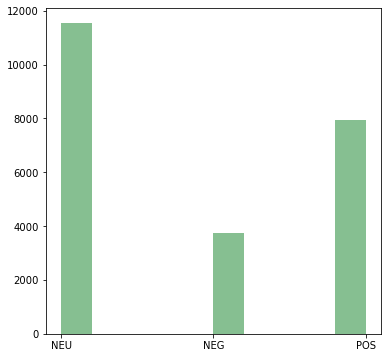

In [9]:
t.vader.hist(grid=False, figsize=(6,6), color='#86bf91')

In [10]:
tosum = t[['time', 'vader_int']]
tosum["time"] = pd.to_datetime(tosum.time, utc = True) 
tosum["min"] = tosum.time.dt.ceil("min")
tosum["min"] = tosum["min"].dt.tz_localize(None)
tosum["hour"] = tosum.time.dt.ceil("H")
tosum["hour"] = tosum["hour"].dt.tz_localize(None)
tosum["day"] = tosum.time.dt.ceil("D")
tosum["day"] = tosum["day"].dt.tz_localize(None)
tosum["pos"] = [1 if i == 1 else 0 for i in tosum.vader_int ]
tosum["neu"] = [1 if i == 0 else 0 for i in tosum.vader_int ]
tosum["neg"] = [1 if i == -1 else 0 for i in tosum.vader_int ]

In [11]:
tosum.head()

,time,vader_int,min,hour,day,pos,neu,neg
0,2022-01-07 16:07:00+00:00,0,2022-01-07 16:07:00,2022-01-07 17:00:00,2022-01-08,0,1,0
1,2022-01-07 16:07:00+00:00,-1,2022-01-07 16:07:00,2022-01-07 17:00:00,2022-01-08,0,0,1
2,2022-01-07 16:08:00+00:00,1,2022-01-07 16:08:00,2022-01-07 17:00:00,2022-01-08,1,0,0
3,2022-01-07 16:16:00+00:00,0,2022-01-07 16:16:00,2022-01-07 17:00:00,2022-01-08,0,1,0
4,2022-01-07 16:19:00+00:00,-1,2022-01-07 16:19:00,2022-01-07 17:00:00,2022-01-08,0,0,1


### Minute

<AxesSubplot:xlabel='min'>

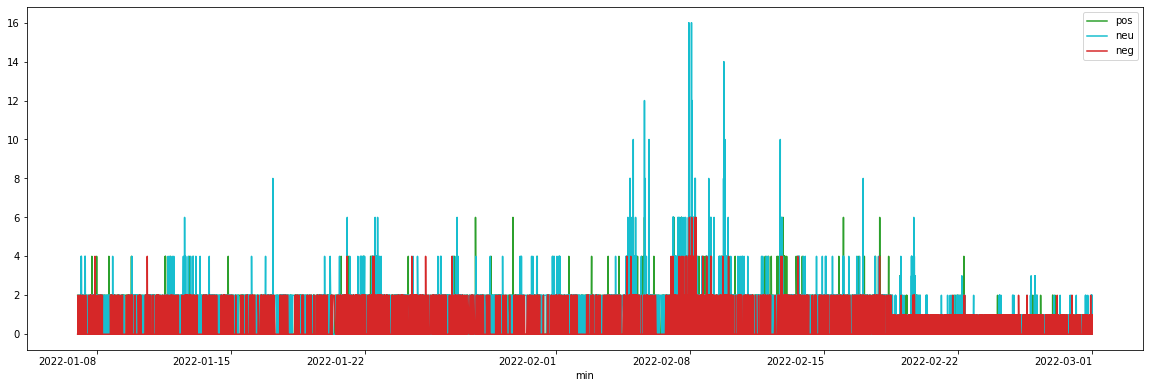

In [12]:
minutesum = tosum.groupby('min').sum()
minutesum["total"] = minutesum.pos + minutesum.neu + minutesum.neg
minutesum.iloc[:, 1:-1].plot(figsize = (20, 7), color = ["tab:green", "tab:cyan","tab:red"], rot = 0)

<AxesSubplot:xlabel='min'>

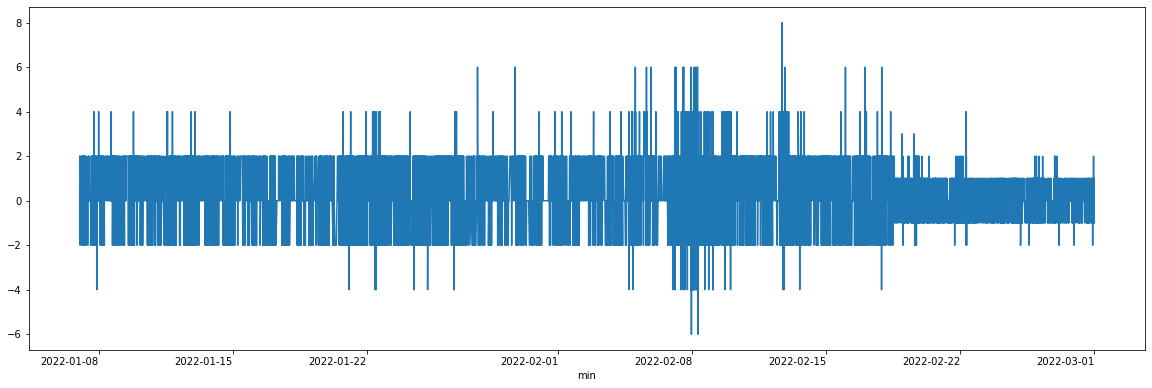

In [13]:
minutesum["vader_int"].plot(figsize = (20, 7), rot = 0)

In [14]:
minutesum = minutesum.reset_index()
minutesum.head()

,min,vader_int,pos,neu,neg,total
0,2022-01-07 00:01:00,2,2,0,0,2
1,2022-01-07 00:07:00,2,2,0,0,2
2,2022-01-07 00:18:00,-1,0,0,1,1
3,2022-01-07 00:34:00,-2,0,0,2,2
4,2022-01-07 00:38:00,0,0,2,0,2


#### Teigiami, neigiami, neutralūs komentarai (minutiniai duomenys)

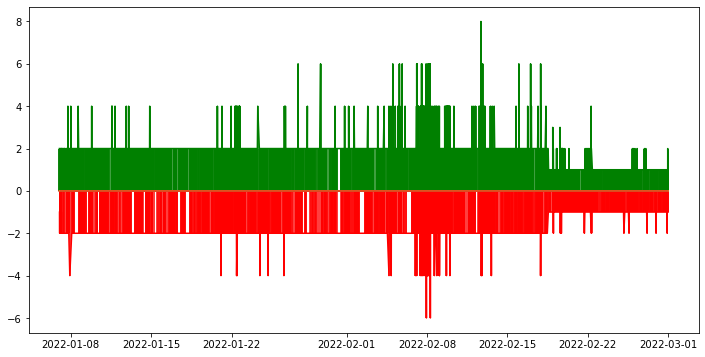

In [37]:
posmin = minutesum.loc[minutesum['vader_int'] > 0]
negmin = minutesum.loc[minutesum['vader_int'] < 0]
neumin = minutesum.loc[minutesum['vader_int'] == 0]

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(6)
plt.stem(posmin['min'], posmin['vader_int'], markerfmt = 'green', linefmt = 'green')
plt.stem(negmin['min'], negmin['vader_int'], markerfmt = 'red', linefmt = 'red')
plt.stem(neumin['min'], neumin['vader_int'], markerfmt = 'yellow', linefmt = 'yellow')
plt.show()

#### Teigiami, neigiami, neutralūs komentarai, padalinti iš visų komentarų skaičiaus tą minutę

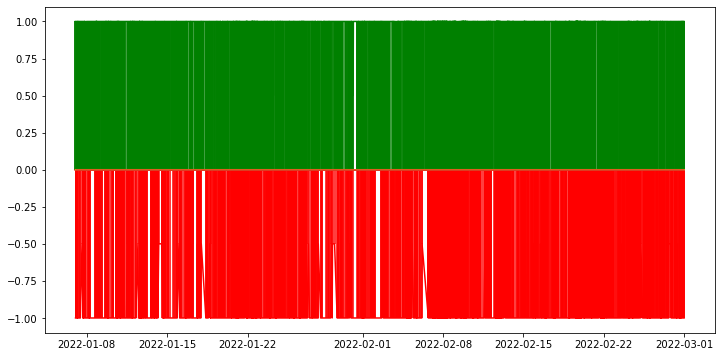

In [38]:
posmin['vader_int/total'] = posmin['vader_int'] / posmin['total']
negmin['vader_int/total'] = negmin['vader_int'] / negmin['total']
neumin['vader_int/total'] = neumin['vader_int'] / neumin['total']

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(6)
plt.stem(posmin['min'], posmin['vader_int/total'], markerfmt = 'green', linefmt = 'green')
plt.stem(negmin['min'], negmin['vader_int/total'], markerfmt = 'red', linefmt = 'red')
plt.stem(neumin['min'], neumin['vader_int/total'], markerfmt = 'yellow', linefmt = 'yellow')
plt.show()

In [16]:
minuteprices = pd.read_csv("raw_data/minute.csv")
minuteprices.time = pd.to_datetime(minuteprices.time,infer_datetime_format = True,  utc = True)
minuteprices.time = minuteprices.time.dt.tz_localize(None)
minuteprices.head()

,time,BTC_price,SPY_price,VXX_price,XAU_price,XRP_price
0,2022-01-07 00:01:00,43111.50,467.965,19.385,1791.5250,0.72640
1,2022-01-07 00:02:00,43107.25,467.965,19.385,1791.4625,0.72640
2,2022-01-07 00:03:00,43112.75,467.965,19.385,1791.5325,0.72645
3,2022-01-07 00:04:00,43091.25,467.965,19.385,1791.6325,0.72665
4,2022-01-07 00:05:00,43080.50,467.965,19.385,1791.7625,0.72665


In [17]:
print("Shape tweets join:", minutesum.shape)
print("Shape prices join:", minuteprices.shape)
minutedf = pd.merge(minuteprices, minutesum, left_on="time", right_on="min", how = 'left')
print("Shape after join:", minutedf.shape)
minutedf = minutedf.drop(['min'], axis = 1)
minutedf = minutedf.fillna(0)
minutedf.head(10)

Shape tweets join: (10656, 6)
Shape prices join: (76312, 6)
Shape after join: (76312, 12)


,time,BTC_price,SPY_price,VXX_price,XAU_price,XRP_price,vader_int,pos,neu,neg,total
0,2022-01-07 00:01:00,43111.50,467.965,19.385,1791.52500,0.72640,2.0,2.0,0.0,0.0,2.0
1,2022-01-07 00:02:00,43107.25,467.965,19.385,1791.46250,0.72640,0.0,0.0,0.0,0.0,0.0
2,2022-01-07 00:03:00,43112.75,467.965,19.385,1791.53250,0.72645,0.0,0.0,0.0,0.0,0.0
3,2022-01-07 00:04:00,43091.25,467.965,19.385,1791.63250,0.72665,0.0,0.0,0.0,0.0,0.0
4,2022-01-07 00:05:00,43080.50,467.965,19.385,1791.76250,0.72665,0.0,0.0,0.0,0.0,0.0
5,2022-01-07 00:06:00,43081.50,467.965,19.385,1791.93500,0.72655,0.0,0.0,0.0,0.0,0.0
6,2022-01-07 00:07:00,43065.50,467.965,19.385,1791.97250,0.72640,2.0,2.0,0.0,0.0,2.0
7,2022-01-07 00:08:00,43031.00,467.965,19.385,1791.89250,0.72610,0.0,0.0,0.0,0.0,0.0
8,2022-01-07 00:09:00,42980.75,467.965,19.385,1791.88675,0.72595,0.0,0.0,0.0,0.0,0.0
9,2022-01-07 00:10:00,42946.75,467.965,19.385,1791.80850,0.72595,0.0,0.0,0.0,0.0,0.0


In [18]:
minutedf.to_csv("data/full_minute.csv", index = False)

### Hour

<AxesSubplot:xlabel='hour'>

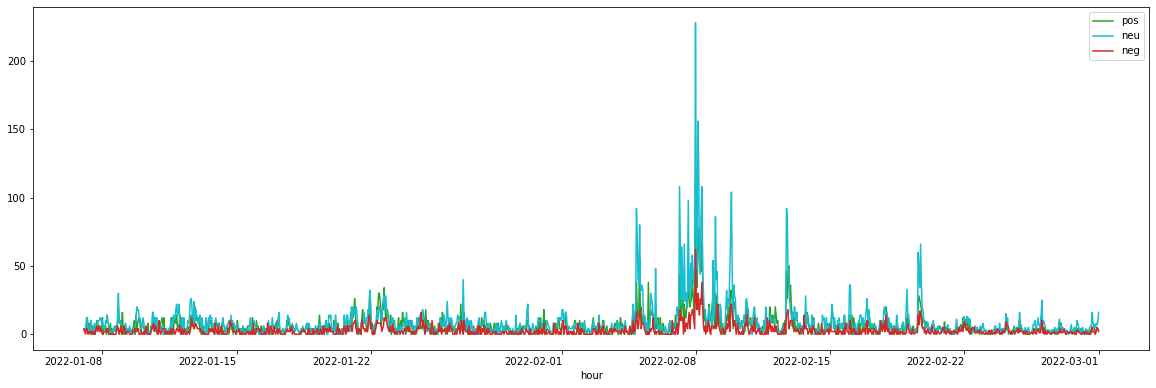

In [29]:
hoursum = tosum.groupby('hour').sum()
hoursum["total"] = hoursum.pos + hoursum.neu + hoursum.neg
hoursum.iloc[:, 1:-1].plot(figsize = (20, 7), color = ["tab:green", "tab:cyan","tab:red"], rot = 0)

<AxesSubplot:xlabel='hour'>

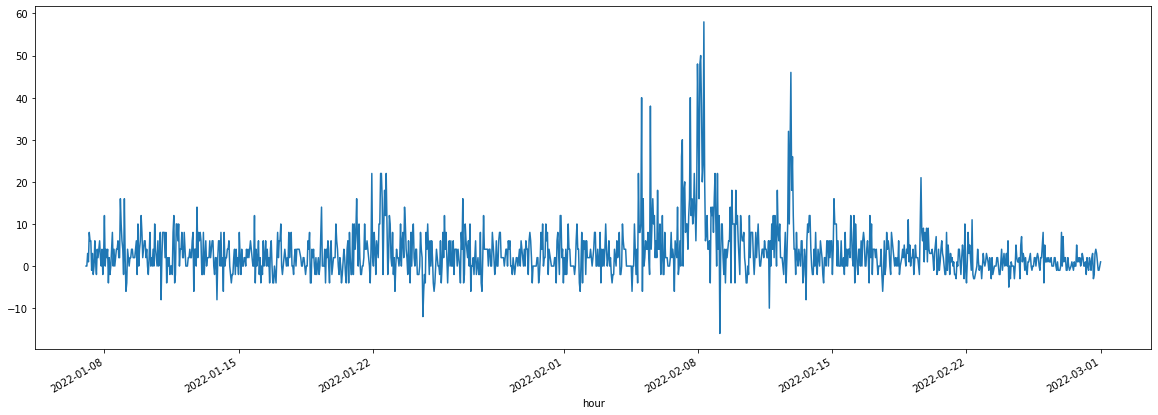

In [30]:
hoursum["vader_int"].plot(figsize = (20, 7))

In [31]:
hoursum = hoursum.reset_index()
hoursum.head()

,hour,vader_int,pos,neu,neg,total
0,2022-01-07 01:00:00,0,4,3,4,11
1,2022-01-07 02:00:00,0,2,2,2,6
2,2022-01-07 03:00:00,3,3,4,0,7
3,2022-01-07 04:00:00,1,5,12,4,21
4,2022-01-07 05:00:00,8,12,12,4,28


#### Teigiami, neigiami, neutralūs komentarai (valandiniai duomenys)

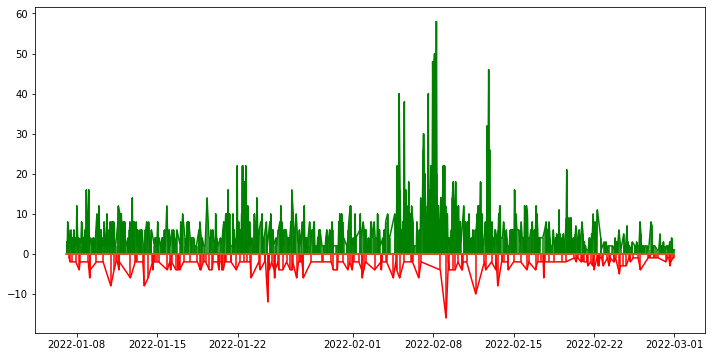

In [39]:
poshour = hoursum.loc[hoursum['vader_int'] > 0]
neghour = hoursum.loc[hoursum['vader_int'] < 0]
neuhour = hoursum.loc[hoursum['vader_int'] == 0]

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(6)
plt.stem(poshour['hour'], poshour['vader_int'], markerfmt = 'green', linefmt = 'green')
plt.stem(neghour['hour'], neghour['vader_int'], markerfmt = 'red', linefmt = 'red')
plt.stem(neuhour['hour'], neuhour['vader_int'], markerfmt = 'yellow', linefmt = 'yellow')
plt.show()

#### Teigiami, neigiami, neutralūs komentarai, padalinti iš visų komentarų skaičiaus tą valandą

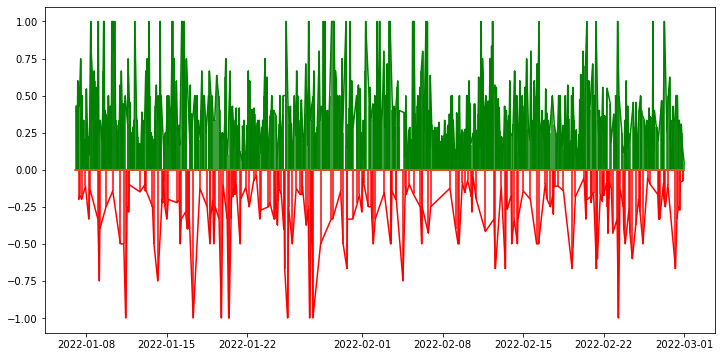

In [41]:
poshour['vader_int/total'] = poshour['vader_int'] / poshour['total']
neghour['vader_int/total'] = neghour['vader_int'] / neghour['total']
neuhour['vader_int/total'] = neuhour['vader_int'] / neuhour['total']

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(6)
plt.stem(poshour['hour'], poshour['vader_int/total'], markerfmt = 'green', linefmt = 'green')
plt.stem(neghour['hour'], neghour['vader_int/total'], markerfmt = 'red', linefmt = 'red')
plt.stem(neuhour['hour'], neuhour['vader_int/total'], markerfmt = 'yellow', linefmt = 'yellow')
plt.show()

In [32]:
hourprices = pd.read_csv("raw_data/hour.csv")
hourprices.time = pd.to_datetime(hourprices.time,infer_datetime_format = True,  utc = True)
hourprices.time = hourprices.time.dt.tz_localize(None)
hourprices.head()

,time,BTC_price,SPY_price,VXX_price,XAU_price,XRP_price
0,2022-01-07 01:00:00,42891.00,467.965,19.385,1791.39075,0.72155
1,2022-01-07 02:00:00,42898.00,467.965,19.385,1791.21500,0.72175
2,2022-01-07 03:00:00,42297.00,467.965,19.385,1792.26825,0.71825
3,2022-01-07 04:00:00,41748.25,467.965,19.385,1792.75150,0.71385
4,2022-01-07 05:00:00,41767.75,467.965,19.385,1791.73325,0.71880


In [33]:
print("Tweets shape:", hoursum.shape)
print("Prices shape:", hourprices.shape)
hourdf = pd.merge(hourprices, hoursum, left_on="time", right_on="hour", how = 'left')
print("Shape after join:", hourdf.shape)
hourdf = hourdf.drop(['hour'], axis = 1)
hourdf = hourdf.fillna(0)
hourdf.head(10)

Tweets shape: (1255, 6)
Prices shape: (1271, 6)
Shape after join: (1271, 12)


,time,BTC_price,SPY_price,VXX_price,XAU_price,XRP_price,vader_int,pos,neu,neg,total
0,2022-01-07 01:00:00,42891.00,467.965,19.385,1791.39075,0.72155,0.0,4.0,3.0,4.0,11.0
1,2022-01-07 02:00:00,42898.00,467.965,19.385,1791.21500,0.72175,0.0,2.0,2.0,2.0,6.0
2,2022-01-07 03:00:00,42297.00,467.965,19.385,1792.26825,0.71825,3.0,3.0,4.0,0.0,7.0
3,2022-01-07 04:00:00,41748.25,467.965,19.385,1792.75150,0.71385,1.0,5.0,12.0,4.0,21.0
4,2022-01-07 05:00:00,41767.75,467.965,19.385,1791.73325,0.71880,8.0,12.0,12.0,4.0,28.0
5,2022-01-07 06:00:00,41676.25,467.965,19.385,1790.38675,0.73125,6.0,6.0,4.0,0.0,10.0
6,2022-01-07 07:00:00,41604.50,467.965,19.385,1789.95425,0.73800,6.0,8.0,4.0,2.0,14.0
7,2022-01-07 08:00:00,41886.25,467.965,19.385,1790.28500,0.74295,-1.0,1.0,2.0,2.0,5.0
8,2022-01-07 09:00:00,42246.00,467.965,19.385,1791.85500,0.74355,3.0,3.0,4.0,0.0,7.0
9,2022-01-07 10:00:00,42299.25,467.965,19.385,1792.26000,0.74540,-2.0,0.0,10.0,2.0,12.0


In [34]:
hourdf.to_csv("data/full_hour.csv", index = False)

### Day 

<AxesSubplot:xlabel='day'>

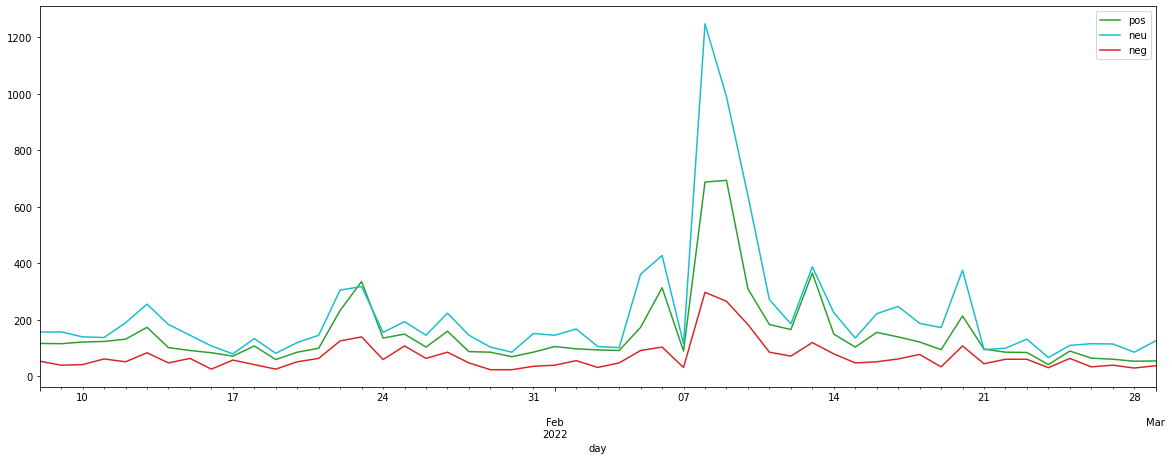

In [42]:
daysum = tosum.groupby('day').sum()
daysum["total"] = daysum.pos + daysum.neu + daysum.neg
daysum.iloc[:, 1:-1].plot(figsize = (20, 7), color = ["tab:green", "tab:cyan","tab:red"], rot = 0)

<AxesSubplot:xlabel='day'>

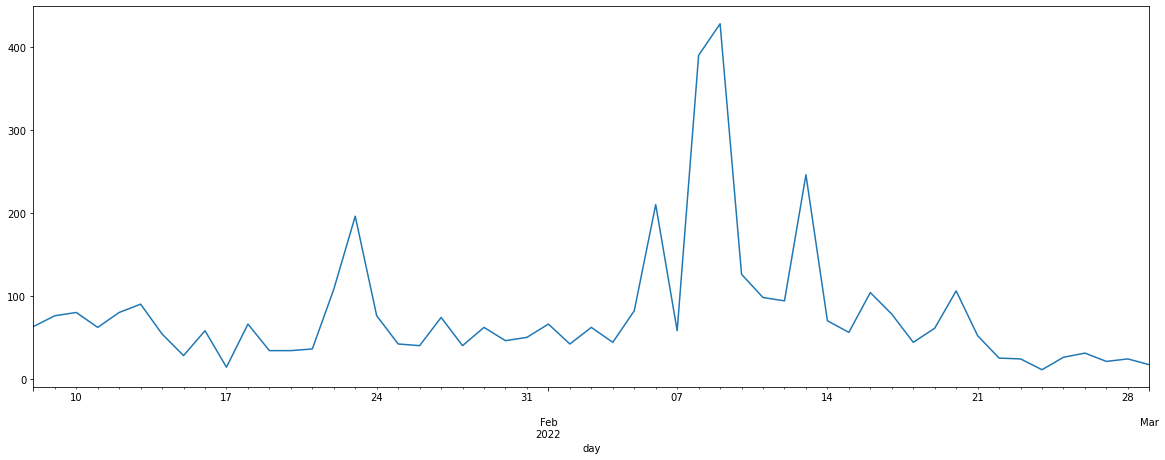

In [43]:
daysum["vader_int"].plot(figsize = (20, 7), rot = 0)

In [44]:
daysum = daysum.reset_index()
daysum.head()

,day,vader_int,pos,neu,neg,total
0,2022-01-08,63,117,157,54,328
1,2022-01-09,76,116,158,40,314
2,2022-01-10,80,122,140,42,304
3,2022-01-11,62,124,138,62,324
4,2022-01-12,80,132,190,52,374


#### Teigiami, neigiami, neutralūs komentarai (valandiniai duomenys)

(0, 6)

Days with positive vader_int - 53
Days with negative vader_int - 0
Days with neutral vader_int - 0


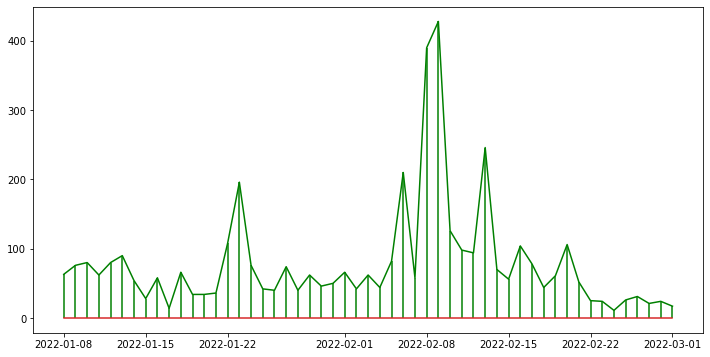

In [57]:
posday = daysum.loc[daysum['vader_int'] > 0]
print("Days with positive vader_int - " + str(posday.shape[0]))
negday = daysum.loc[daysum['vader_int'] < 0]
print("Days with negative vader_int - " + str(negday.shape[0]))
neuday = daysum.loc[daysum['vader_int'] == 0]
print("Days with neutral vader_int - " + str(neuday.shape[0]))


f = plt.figure()
f.set_figwidth(12)
f.set_figheight(6)
plt.stem(posday['day'], posday['vader_int'], markerfmt = 'green', linefmt = 'green')
#plt.stem(negday['day'], negday['vader_int'], markerfmt = 'red', linefmt = 'red')
#plt.stem(neuday['day'], neuday['vader_int'], markerfmt = 'yellow', linefmt = 'yellow')
plt.show()

#### Teigiami, neigiami, neutralūs komentarai, padalinti iš visų komentarų skaičiaus tą valandą

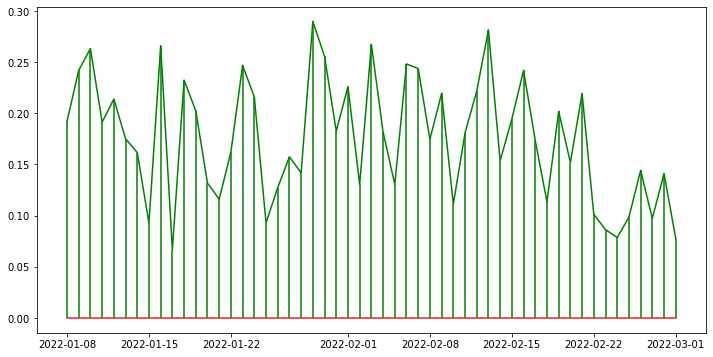

In [58]:
posday['vader_int/total'] = posday['vader_int'] / posday['total']

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(6)
plt.stem(posday['day'], posday['vader_int/total'], markerfmt = 'green', linefmt = 'green')
plt.show()

In [45]:
dayprices = pd.read_csv("raw_data/day.csv")
dayprices.time = pd.to_datetime(dayprices.time,infer_datetime_format = True,  utc = True)
dayprices.time = dayprices.time.dt.tz_localize(None)
dayprices.head()

,time,BTC_price,SPY_price,VXX_price,XAU_price,XRP_price
0,2022-01-07,42323.75,467.0225,19.080,1793.90675,0.76155
1,2022-01-08,41620.75,466.1150,18.820,1796.37500,0.76140
2,2022-01-09,41777.50,466.1150,18.820,1795.09750,0.76160
3,2022-01-10,41845.25,464.0800,19.020,1798.24325,0.76145
4,2022-01-11,42282.75,467.4850,18.265,1811.06075,0.76130


In [46]:
print("Tweets shape:", daysum.shape)
print("Prices shape:", dayprices.shape)
daydf = pd.merge(dayprices, daysum, left_on="time", right_on="day", how = 'left')
print("Shape after join:", daydf.shape)
daydf = daydf.drop(['day'], axis = 1)
daydf = daydf.fillna(0)
daydf.head(10)

Tweets shape: (53, 6)
Prices shape: (55, 6)
Shape after join: (55, 12)


,time,BTC_price,SPY_price,VXX_price,XAU_price,XRP_price,vader_int,pos,neu,neg,total
0,2022-01-07,42323.75,467.0225,19.0800,1793.90675,0.76155,0.0,0.0,0.0,0.0,0.0
1,2022-01-08,41620.75,466.1150,18.8200,1796.37500,0.76140,63.0,117.0,157.0,54.0,328.0
2,2022-01-09,41777.50,466.1150,18.8200,1795.09750,0.76160,76.0,116.0,158.0,40.0,314.0
3,2022-01-10,41845.25,464.0800,19.0200,1798.24325,0.76145,80.0,122.0,140.0,42.0,304.0
4,2022-01-11,42282.75,467.4850,18.2650,1811.06075,0.76130,62.0,124.0,138.0,62.0,324.0
5,2022-01-12,43325.50,471.3300,17.6275,1823.09325,0.76125,80.0,132.0,190.0,52.0,374.0
6,2022-01-13,43242.50,468.4450,18.1550,1823.14250,0.76080,90.0,174.0,256.0,84.0,514.0
7,2022-01-14,42831.25,463.0425,18.8875,1819.41500,0.76055,54.0,102.0,184.0,48.0,334.0
8,2022-01-15,43087.75,464.9250,18.4050,1817.91000,0.76060,28.0,92.0,146.0,64.0,302.0
9,2022-01-16,43085.00,464.9250,18.4050,1817.25750,0.76035,58.0,84.0,108.0,26.0,218.0


In [47]:
daydf.to_csv("data/full_day.csv", index = False)